     block, center = (-0.24,-1.51,0)
          size (0.005,0.005,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.0625,5.0625,5.0625)
     block, center = (-0.24,-1.5,0)
          size (0.005,0.005,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.0625,5.0625,5.0625)
     block, center = (-0.23,-1.53,0)
          size (0.005,0.005,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.0625,5.0625,5.0625)
     block, center = (-0.23,-1.52,0)
          size (0.005,0.005,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.0625,5.0625,5.0625)
     block, center = (-0.23,-1.51,0)
          size (0.005,0.005,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.0625,5.0625,5.0625)
     block, center = (-0.23,-1.5,0)
          size (0.005,0.005,0)
          axes (1,0,0), (0,1,

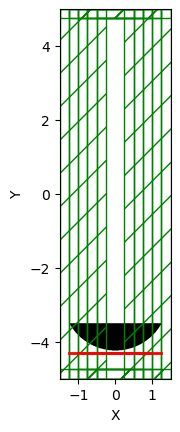

In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
import nlopt
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
from matplotlib import pyplot as plt
import os
import math

mp.verbosity(1)

SiO2 = mp.Medium(index=1.5*1.5)

diameter_values = [0.5, 1.0, 1.5, 2.0, 2.5]

for diameter_val in diameter_values:
    # Update diameter in the simulation parameters
    diameter = diameter_val

    # Constants
    PI = np.pi

    import math

    # Constants
    a = 1.0
    scale_down = 1

    # Geometry properties
    Lx = diameter / (a * scale_down)
    Ly = 2.0 * Lx
    resolution = 100
    Lpml = 0.25

    pml_layers = [mp.PML(thickness = Lpml,)]

    # Position information
    src_ypos = Ly - Lpml - 0.25
    transmission_ypos = Lpml + 1.0


    # Parameters of the Plano convex lens
    d = (diameter / (a * scale_down)) / 2.0
    focal = d * math.sqrt(21.0) / 2.0
    r_cur = focal / (2 * a * scale_down)
    sin_NA = d / math.sqrt(d * d + focal * focal)
    k_airy = 2.0 * math.pi / 1.0
    airy_NA = 0.38317 * Lx / 2.0
    lens_ypos = src_ypos - 0.5
    x_center = Lx / 2.0
    y_center = lens_ypos + math.sqrt(r_cur * r_cur - d * d)


    # source 설정
    width = 0.1

    fcen_red = 1/(0.65)
    fwidth_red = fcen_red * width

    fcen_green = 1/(0.55)
    fwidth_green = fcen_green * width

    fcen_blue = 1/(0.45)
    fwidth_blue = fcen_blue * width

    src_0 = mp.GaussianSource(frequency=fcen_red, fwidth=fwidth_red, is_integrated=True)

    src_1 = mp.GaussianSource(frequency=fcen_green, fwidth=fwidth_green, is_integrated=True)

    src_2 = mp.GaussianSource(frequency=fcen_blue, fwidth=fwidth_blue, is_integrated=True)

    source_center = [0, -4.3] # Source 위치
    source_size = mp.Vector3(d*2)

    source = [mp.Source(src_2, component=mp.Ez, size=source_size, center=source_center,)]

    cell = mp.Vector3(d*2+Lpml*2,10)
    # cell = mp.Vector3(10, 10)

    geometry = [
        # mp.Block(
        #     center=mp.Vector3(y=lens_ypos-et/2), size=mp.Vector3(d*2,et), material=SiO2
        # )
    ]
    for pos_x in np.arange(-10, 10, 0.01):
        for pos_y in np.arange(-10, 10, 0.01):
            if pos_y<=(lens_ypos):
                if ((pos_x-x_center)*(pos_x-x_center) + (pos_y-y_center)*(pos_y-y_center) <= (r_cur*r_cur)):
                    geometry.append(mp.Block(center=mp.Vector3(pos_x -diameter/2, pos_y-d*6), size=mp.Vector3(0.5/resolution, 0.5/resolution), material=SiO2))


    sim = mp.Simulation(
        cell_size=cell, 
        boundary_layers=pml_layers,
        geometry=geometry,
        sources=source,
        resolution=resolution,
    )
    sim.plot2D()

    tran_total0 = sim.add_dft_fields([mp.Ez], fcen_red, 0 , 1, center=mp.Vector3(0, 0, 0), size=mp.Vector3(d*2+Lpml*4,10), yee_grid=True)


    tran_Ex = sim.add_dft_fields([mp.Ex], fcen_blue, 0 , 1, center=mp.Vector3(0, 0, 0), size=mp.Vector3(d*2+Lpml*4,10), yee_grid=True)
    tran_Ey = sim.add_dft_fields([mp.Ey], fcen_blue, 0 , 1, center=mp.Vector3(0, 0, 0), size=mp.Vector3(d*2+Lpml*4,10), yee_grid=True)
    tran_Ez = sim.add_dft_fields([mp.Ez], fcen_blue, 0 , 1, center=mp.Vector3(0, 0, 0), size=mp.Vector3(d*2+Lpml*4,10), yee_grid=True)
    tran_Hx = sim.add_dft_fields([mp.Hx], fcen_blue, 0 , 1, center=mp.Vector3(0, 0, 0), size=mp.Vector3(d*2+Lpml*4,10), yee_grid=True)
    tran_Hy = sim.add_dft_fields([mp.Hy], fcen_blue, 0 , 1, center=mp.Vector3(0, 0, 0), size=mp.Vector3(d*2+Lpml*4,10), yee_grid=True)
    tran_Hz = sim.add_dft_fields([mp.Hz], fcen_blue, 0 , 1, center=mp.Vector3(0, 0, 0), size=mp.Vector3(d*2+Lpml*4,10), yee_grid=True)
    pt = mp.Vector3(0,lens_ypos-focal,0)

    sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, pt, 1e-3)) 

    Ex_Namei="Ex_r_field"
    Ey_Namei="Ey_r_field"
    Ez_Namei="Ez_r_field"

    Hx_Namei="Hx_r_field"
    Hy_Namei="Hy_r_field"
    Hz_Namei="Hz_r_field"



    sim.output_dft(tran_Ex,str(diameter)+Ex_Namei)
    sim.output_dft(tran_Ey,str(diameter)+Ey_Namei)
    sim.output_dft(tran_Ez,str(diameter)+Ez_Namei)

    sim.output_dft(tran_Hx,str(diameter)+Hx_Namei)
    sim.output_dft(tran_Hy,str(diameter)+Hy_Namei)
    sim.output_dft(tran_Hz,str(diameter)+Hz_Namei)

    sim.reset_meep()